# Import necessary packages

In [1]:
import pandas as pd
import re
import string
import numpy as np
from sentiment_module import sentiment
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import gutenberg
from pprint import pprint
import seaborn as sns
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
# df[df['review_id']=='cc0pfhAB-JIeBVeKJ1BM-A']

# Load Data

In [3]:
# read pizza data

df=pd.read_csv('top_pizza_reviews.csv')

In [4]:
df.shape

(20877, 17)

In [5]:
df.columns

Index(['business_id', 'name', 'biz_stars', 'state', 'city', 'neighborhood',
       'address', 'postal_code', 'review_id', 'text', 'date', 'cool', 'funny',
       'useful', 'stars', 'user_id', 'type'],
      dtype='object')

# EDA

In [6]:
# most popular restaurant (by count of review per restaurant name)
df.groupby(['name'])[['text']].count()\
    .sort_values('text',ascending=False)

,text
name,
Grimaldi's Pizzeria,5190
Pizza Hut,4184
Domino's Pizza,3232
Mellow Mushroom,2753
Blaze Fast-Fire'd Pizza,2214
Papa John's Pizza,2070
Papa Murphy's,998
Little Caesars,236


In [7]:
# most popular restaurant (by count of review per restaurant name)
df.groupby(['type'])[['text']].count()

,text
type,
Delivery,9722
Dine-in,7943
Fast Casual,2214
Take and Bake,998


In [8]:
# review per business
df.groupby(['name'])[['address']].nunique().sort_values('address',ascending=False)

,address
name,
Pizza Hut,318
Domino's Pizza,233
Papa John's Pizza,149
Papa Murphy's,67
Little Caesars,34
Blaze Fast-Fire'd Pizza,13
Grimaldi's Pizzeria,11
Mellow Mushroom,9


## Remove punctuation line

In [9]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

In [10]:
df['puncount']=df['text'].apply(lambda x: count(x,set(string.punctuation))/len(x))

In [11]:
df.sort_values(by='puncount',ascending=False)['text'].head()

4734     ********** $9.99 For A 14" Circle of Crap ****...
4389     delivery has taken a half an hou already! not ...
5545     fast and tasty...............delivery driver B...
19541    STAFF+TIME------------------------------------...
6447     Have to say they're fast ...\nThe delivery guy...
Name: text, dtype: object

count    20877.000000
mean         0.031995
std          0.014593
min          0.000000
25%          0.022915
50%          0.029740
75%          0.038128
max          0.243590
Name: puncount, dtype: float64


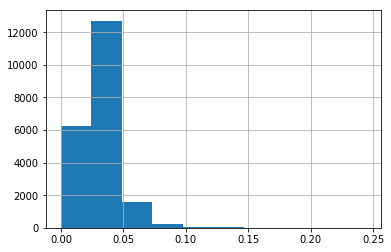

In [12]:
print(df['puncount'].describe())
df['puncount'].hist()

In [13]:
# # drop
# df = df[df['puncount'] < 0.1]
# print(df['puncount'].describe())
# df['puncount'].hist()

## Language detect

In [14]:
from langdetect import detect

In [15]:
def detectexception(text):
    try:
        return detect(text)
    except:
        return 'NaL' # return not a language

In [16]:
# detect language (run for a while)
df['lan']=df['text'].apply(lambda x:detectexception(x))
#df=df.rename(index=str, columns={"lan1": "lan"})

CPU times: user 2min 17s, sys: 5.41 s, total: 2min 23s
Wall time: 2min 23s


In [17]:
# get language count
df.groupby(['lan'])[['text']].count().sort_values('text',ascending=False)

CPU times: user 30.4 ms, sys: 3.77 ms, total: 34.1 ms
Wall time: 31.7 ms


,text
lan,
en,20833
it,16
fr,14
de,3
es,3
af,2
et,2
da,1
pl,1


In [18]:
df[df['lan']!='en'].head()

,business_id,name,biz_stars,state,city,neighborhood,address,postal_code,review_id,text,date,cool,funny,useful,stars,user_id,type,puncount,lan
122,vQXhuCQ4Wc3WWesp9hy3VQ,Pizza Hut,1.5,ON,Toronto,St. Lawrence,77 Lower Jarvis,M5E 1R8,gJ32Kq6Wwq6Pr9_dwj_C_w,"Gross pizza, better than pizza pizza, but stil...",2017-08-08,0,0,1,2,723Rler7IsBi80ps97vrxA,Delivery,0.055556,it
217,XT7-XSDM3kGS4KYS6AkZjg,Pizza Hut,2.5,QC,Lasalle,LaSalle,7551 Boulevard Newman,H8N 1X3,dhvokw5bM3MdQm85xR3fZg,Très mauvais service nous avons attendu au moi...,2015-12-03,0,0,0,2,dR0Eo3A6AKE_Hj5MxbVhmQ,Delivery,0.011811,fr
224,XT7-XSDM3kGS4KYS6AkZjg,Pizza Hut,2.5,QC,Lasalle,LaSalle,7551 Boulevard Newman,H8N 1X3,CmMgk7W1xu_fH-b22nLfXg,Je sais que je ne devais pas m'attendre à de l...,2015-11-28,1,1,1,2,x459culD4Wy_auLcAoQgrw,Delivery,0.023636,fr
225,XT7-XSDM3kGS4KYS6AkZjg,Pizza Hut,2.5,QC,Lasalle,LaSalle,7551 Boulevard Newman,H8N 1X3,UA5RCkj6LzxKaW-6cm2X0Q,J'aime bien Pizza Hut surtout pour leur croûte...,2017-07-10,2,1,4,4,MD-QMO8zcqd584wcpzo9sg,Delivery,0.017391,fr
375,fsMgUPvNasNOMoz5yx680Q,Pizza Hut,2.5,QC,Laval,Laval,1700 Boulevard des Laurentides,H7M 2Y4,1FZ-vdLjcGACFgit1uTOHg,Plus mauvaise expérience client que j'ai eu de...,2017-04-19,0,0,0,1,_xJx7K2tq71hJUGxUOzUYw,Delivery,0.038339,fr


In [19]:
import wordcloud

## Sentence tokenize

count    20877.000000
mean         7.348853
std          5.924358
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         96.000000
Name: reviewsenlen, dtype: float64

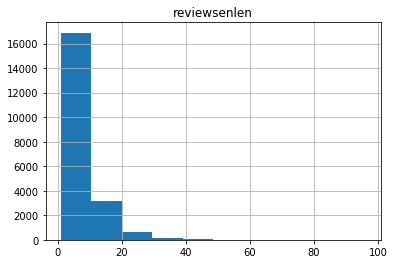

In [20]:
# get sentences of review
default_st=nltk.sent_tokenize
df['reviewsen']=df.text.apply(lambda x: default_st(text=x))
df['reviewsenlen']=df.reviewsen.apply(len)
# review sentences stat
df.hist('reviewsenlen')
df['reviewsenlen'].describe()

Text(0,0.5,'review length')

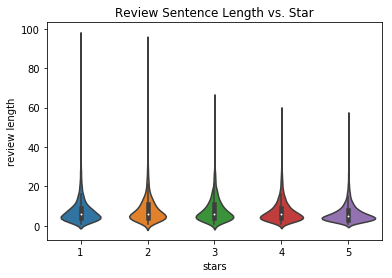

In [21]:
# if sentence lenth are related to review stars
sns.violinplot(x='stars',y='reviewsenlen',data=df).set_title('Review Sentence Length vs. Star')
plt.ylabel('review length')

In [22]:
# look at some longest reviews
for i in df[df['reviewsenlen']>80]['reviewsen'].head():
    pprint(i)

["This review is about this one location's unacceptable behavior.",
 "To start, I like Papa John's.",
 '* The pizza is reasonably tasty for my family (not as good as the local top '
 'notch mom  & pop places, but decent none-the-less.)',
 '* The value is exceptional - they have the best specials, which we always '
 'take advantage of.',
 'Their online ordering and REWARD program is unparalleled (I belong to  every '
 'chains reward and email clubs, they are all pathetic.',
 "Not PJ's!",
 'Join and find out!)',
 '* My local PJ is a franchise that in my opinion is a model for any franchise '
 'of any type.',
 'They know us by face and by name and greet us so when we come in.',
 'The food is well prepared and consistent.',
 'They service is fast and extra friendly.',
 'They rarely screw-up; and IF they do they are apologetic and fast to fix it '
 'in a method that we prefer.',
 'So... What about THIS LOCATION??',
 'We were having a family gathering in Phoenix and someone said "Let\'s get 

In [23]:
# get length of review
df.loc[:,'reviewlen']=df.loc[:,'text'].apply(len)

count    20877.000000
mean       527.401207
std        483.445307
min          2.000000
25%        219.000000
50%        378.000000
75%        672.000000
max       5000.000000
Name: reviewlen, dtype: float64

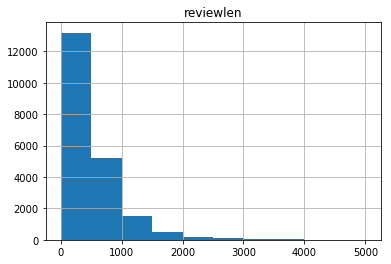

In [24]:
# review length stat
df.hist('reviewlen')
df.loc[:,'reviewlen'].describe()

## Word Tokenize

count    20877.000000
mean       113.180773
std        104.224505
min          1.000000
25%         47.000000
50%         81.000000
75%        144.000000
max       1119.000000
Name: reviewwordlen, dtype: float64

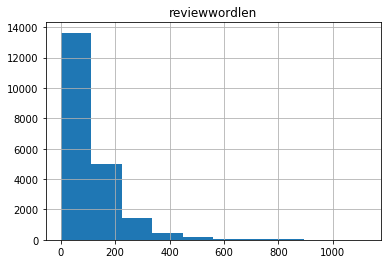

In [25]:
# get sentences of review
default_wt=nltk.word_tokenize
df['reviewword']=df.text.apply(lambda x: default_wt(text=x))
df['reviewwordlen']=df.reviewword.apply(len)
# review sentences stat
df.hist('reviewwordlen')
df['reviewwordlen'].describe()

count    20877.000000
mean        15.791324
std          8.867116
min          1.000000
25%         11.125000
50%         14.333333
75%         18.200000
max        218.000000
Name: avgword, dtype: float64

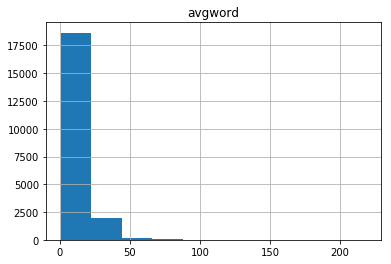

In [26]:
# people couldn't write and using comma all the time

df.loc[:,'avgword']=df.loc[:,'reviewwordlen']/df.loc[:,'reviewsenlen']
# review length stat
df.hist('avgword')
df.loc[:,'avgword'].describe()

In [27]:
sum(df['avgword']>200)

1

In [28]:
print(df[df['avgword']>200]['text'])

14844    The manager Johnny is an idiot I do not know i...
Name: text, dtype: object


## People tend to star higher

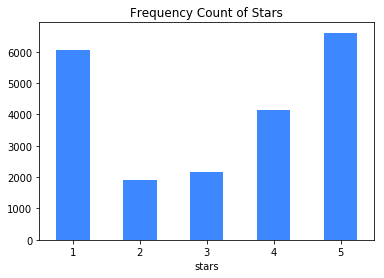

In [29]:
# star distributions
#df['stars'].hist(bins=5)
#df['stars'].value_counts().plot(kind='bar') this code doesn't sort ordinal
ax=df.groupby('stars').size().plot(kind='bar',title="Frequency Count of Stars",
                                   rot=0,color='#3d87ff')

In [30]:
print('There are',len(df.address.unique()),'restaurants')

There are 834 restaurants


In [31]:
# check na values for each column
df.isna().sum()

business_id          0
name                 0
biz_stars            0
state                0
city                 0
neighborhood     12179
address              0
postal_code          0
review_id            0
text                 0
date                 0
cool                 0
funny                0
useful               0
stars                0
user_id              0
type                 0
puncount             0
lan                  0
reviewsen            0
reviewsenlen         0
reviewlen            0
reviewword           0
reviewwordlen        0
avgword              0
dtype: int64

## sentiment analysis (dr healey model)

In [32]:
# df['sentiment']=df['text'].apply(str.split).apply(sentiment.sentiment)
# df=pd.concat([df['sentiment'].apply(pd.Series),df.drop('sentiment',axis=1)],axis=1)
df=pd.concat([df['text'].apply(str.split).apply(sentiment.sentiment).apply(pd.Series),df],axis=1)

CPU times: user 13.1 s, sys: 269 ms, total: 13.4 s
Wall time: 13.5 s


In [33]:
df=df.drop(df[df['valence']==0].index)

CPU times: user 37.5 ms, sys: 5.54 ms, total: 43 ms
Wall time: 41.3 ms


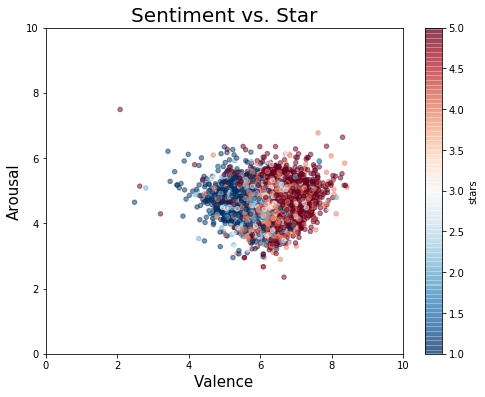

In [34]:
fig, ax = plt.subplots()
df.plot.scatter(x='valence',y='arousal',c='stars',fontsize=10,
               colormap='RdBu_r',ax=ax,alpha=0.5,
               figsize=(8, 6))
ax.set_title('Sentiment vs. Star',fontsize=20)
ax.set_xlabel('Valence',fontsize=15)
ax.set_ylabel('Arousal',fontsize=15)
plt.xlim(0,10)
plt.ylim(0,10)
plt.savefig('sentiment-all.png')
plt.show()

In [35]:
colors=['#6c0521','#7d14a5','#c84678','#f5914b','#0d3a67']

In [36]:
# for i in range(1,6):
#     fig, ax = plt.subplots()
#     df[df['stars']==i].plot.scatter(x='valence',y='arousal', color=colors[i-1],
#                                     ax=ax, alpha=0.5,title='Sentiment vs. Star '+str(i),
#                                     figsize=(8, 6))
#     plt.xlim(0,10)
#     plt.ylim(0,10)
#     plt.savefig('sentiment'+str(i)+'.png')

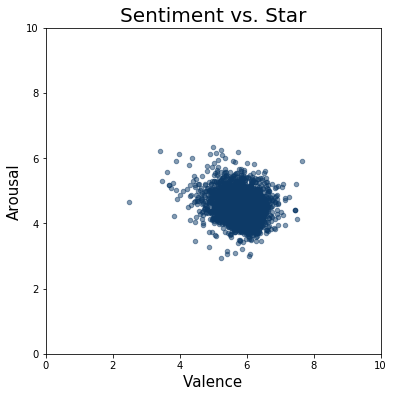

In [37]:
fig, ax = plt.subplots()
df[df['stars']==1].plot.scatter(x='valence',y='arousal', color='#0d3a67',fontsize=10,
                                ax=ax, alpha=0.5,
                                figsize=(6, 6))
ax.set_title('Sentiment vs. Star',fontsize=20)
ax.set_xlabel('Valence',fontsize=15)
ax.set_ylabel('Arousal',fontsize=15)
plt.xlim(0,10)
plt.ylim(0,10)
plt.savefig('sentiment-1.png')

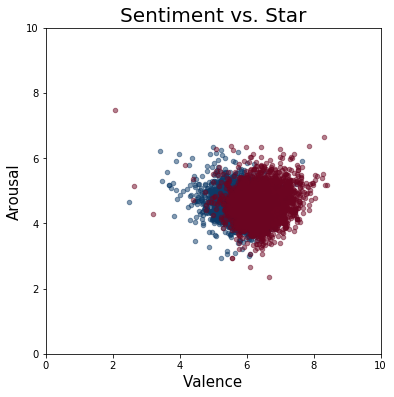

In [38]:
fig, ax = plt.subplots()
df[df['stars']==1].plot.scatter(x='valence',y='arousal', color='#0d3a67',fontsize=10,
                                ax=ax, alpha=0.5,
                                figsize=(6, 6))
df[df['stars']==5].plot.scatter(x='valence',y='arousal', color='#6c0521',fontsize=10,
                                ax=ax, alpha=0.5,
                                figsize=(6, 6))

ax.set_title('Sentiment vs. Star',fontsize=20)
ax.set_xlabel('Valence',fontsize=15)
ax.set_ylabel('Arousal',fontsize=15)
plt.xlim(0,10)
plt.ylim(0,10)
plt.savefig('sentiment15.png')

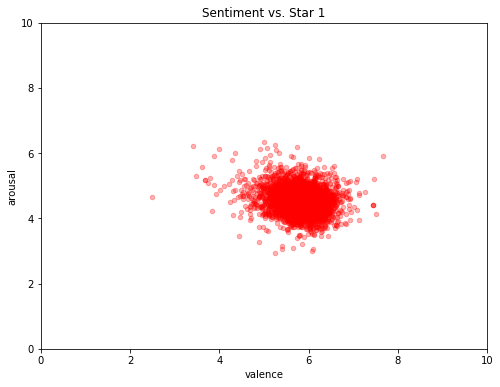

In [39]:
i=1
fig, ax = plt.subplots()
df[df['stars']==i].plot.scatter(x='valence',y='arousal', color='Red',
                                ax=ax, alpha=0.3,title='Sentiment vs. Star '+str(i),
                                figsize=(8, 6))
plt.xlim(0,10)
plt.ylim(0,10)
plt.savefig('sentiment'+str(i)+'.png')

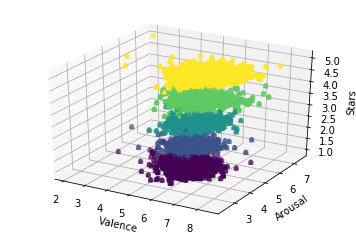

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = df['valence']
    ys = df['arousal']
    zs = df['stars']
    ax.scatter(xs, ys, zs, c=df['stars'], marker=m)

ax.set_xlabel('Valence')
ax.set_ylabel('Arousal')
ax.set_zlabel('Stars')

plt.show()

In [41]:
df.columns

Index(['valence', 'arousal', 'business_id', 'name', 'biz_stars', 'state',
       'city', 'neighborhood', 'address', 'postal_code', 'review_id', 'text',
       'date', 'cool', 'funny', 'useful', 'stars', 'user_id', 'type',
       'puncount', 'lan', 'reviewsen', 'reviewsenlen', 'reviewlen',
       'reviewword', 'reviewwordlen', 'avgword'],
      dtype='object')

In [42]:
df[(df['valence']<3) & (df['stars']>4) & (df['arousal']>7)]

,valence,arousal,business_id,name,biz_stars,state,city,neighborhood,address,postal_code,...,user_id,type,puncount,lan,reviewsen,reviewsenlen,reviewlen,reviewword,reviewwordlen,avgword
11717,2.08,7.49,YQ--LJ7pvjiDSqNv0TuKTQ,Grimaldi's Pizzeria,4.0,NV,Las Vegas,The Strip,"3327 Las Vegas Blvd S, Ste 2710",89109,...,njOy2Wo3v1ioDgvu6nR9oQ,Dine-in,0.059322,de,"[Sehr gute Pizza zum selbst zusammenstellen., ...",2,118,"[Sehr, gute, Pizza, zum, selbst, zusammenstell...",24,12.0


### NLTK Sentiment

In [43]:
from nltk.corpus import sentiwordnet as swn

In [44]:
def normalize_accented_characters(text):
    '''
    removes accents from characters and replaces with non-accented equivalent
    '''
    if type(text) != str:
        text = (unicodedata.normalize('NFKD', text.decode('utf-8'))
                           .encode('ascii', 'ignore'))
    return text

In [45]:
def analyze_sentiment_sentiwordnet_lexicon(review, verbose=False):
    '''
    analyzes sentiment of text using 
    '''
    # pre-process text
    review = normalize_accented_characters(review)
    
    # tokenize and POS tag text tokens
    text_tokens = nltk.word_tokenize(review)
    tagged_text = nltk.pos_tag(text_tokens)
    pos_score = neg_score = token_count = obj_score = 0
    
    # get wordnet synsets based on POS tags for NN, VB, JJ, RB
    # get sentiment scores if synsets are found
    for word, tag in tagged_text:  
        ss_set = None
        if 'NN' in tag and list(swn.senti_synsets(word, 'n')): # singular noun
            ss_set = list(swn.senti_synsets(word, 'n'))[0]
        elif 'VB' in tag and list(swn.senti_synsets(word, 'v')): # Verb
            ss_set = list(swn.senti_synsets(word, 'v'))[0]
        elif 'JJ' in tag and list(swn.senti_synsets(word, 'a')): # Adjective
            ss_set = list(swn.senti_synsets(word, 'a'))[0]
        elif 'RB' in tag and list(swn.senti_synsets(word, 'r')): # adverb
            ss_set = list(swn.senti_synsets(word, 'r'))[0]
        
        # if senti-synset is found
        if ss_set:
            # add scores for all found synsets
            pos_score += ss_set.pos_score()
            neg_score += ss_set.neg_score()
            obj_score += ss_set.obj_score()
            token_count += 1
        
        # if no words have synset, return None 
        if token_count == 0:
            return None
        
    # aggregate final scores
    final_score = pos_score - neg_score
    norm_final_score = round(float(final_score) / token_count, 2)
    final_sentiment = 'positive' if norm_final_score >= 0 else 'negative'
    if verbose:
        norm_obj_score = round(float(obj_score) / token_count, 2)
        norm_pos_score = round(float(pos_score) / token_count, 2)
        norm_neg_score = round(float(neg_score) / token_count, 2)
        # to display results in a nice table
        sentiment_frame = pd.DataFrame([[final_sentiment, norm_obj_score,
                                         norm_pos_score, norm_neg_score,
                                         norm_final_score]],
                                         columns=pd.MultiIndex(
                                             levels=[['SENTIMENT STATS:'],
                                                ['Predicted Sentiment',
                                                 'Objectivity',
                                                 'Positive', 'Negative',
                                                 'Overall']],
                                              labels=[[0,0,0,0,0],
                                                      [0,1,2,3,4]]))
        print(sentiment_frame)
    return final_sentiment

In [46]:
# takes a while to run
df['pred_sentiment'] = df['text'].apply(analyze_sentiment_sentiwordnet_lexicon)

In [47]:
df['pred_sentiment'].head()

0    negative
1    negative
2    positive
3        None
4        None
Name: pred_sentiment, dtype: object

In [48]:
# how many not matching
highstarlowsent = (df.stars == 5) & (df.valence < 3)
print('total non matching:',highstarlowsent.sum())
df[highstarlowsent].text.head()

total non matching: 2


9996     Love the environment. Great waiter Nick. Super...
11717    Sehr gute Pizza zum selbst zusammenstellen.\n\...
Name: text, dtype: object

In [49]:
# how many not matching
lowstarhighsent = (df.stars <2) & (df.valence > 7)
print('total non matching:',lowstarhighsent.sum())
df[lowstarhighsent].text.iloc[3]

total non matching: 14


'This restaurant is very dirty. Staff is never pleasant to customers, and the food is over priced.'

# Data Clean

## Clean Function

In [50]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(('pizza','pizzas','would','dont','didnt'))
string.punctuation
nolem = []
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

def clean_text(text, join=False, stem='lemmatize'):
    # lower case and remove punctuation, here word is char so need '' to join these char back
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    
    text=re.sub(r'\d+', '', text)
    
    # break down to tokens (single word)
    tokens = re.split('\W+', text)
    
    # special words no lemmatize, and remove stop words
    # elif list comprehension: [if-1 condition_1 else_2 for_statement <condition_2>]
    
    if stem == 'lemmatize':
        if join == True:
            text = ' '.join([word if word in nolem else wn.lemmatize(word,'v') for word in tokens if word not in stopwords ])
        else:
            text = [word if word in nolem else wn.lemmatize(word,'v') for word in tokens if word not in stopwords ]
    elif stem == 'stem':
        if join == True:
            text = ' '.join([word if word in nolem else ps.stem(word) for word in tokens if word not in stopwords ])
        else:
            text = [word if word in nolem else ps.stem(word) for word in tokens if word not in stopwords ]
    #nostop = [word for word in tokens if word not in stopwords]
    #text = [wn.lemmatize(word) if word not in nolem else word for word in nostop]
    #text=[]
    #for word in tokens:
    #    if word in nolem:
    #        text.append(word)
    #    elif word not in stopwords:
    #        text.append(wn.lemmatize(word))
    return text

In [51]:
df['cleaned_text']=df['text'].apply(clean_text)

CPU times: user 13.9 s, sys: 86.1 ms, total: 14 s
Wall time: 14 s


In [52]:
df['cleaned_text'].head()

0    [displease, come, later, schedule, cold, box, ...
1    [order, location, literally, front, apartment,...
2    [busy, place, take, good, care, right, away, w...
3    [stop, pick, order, wing, way, home, work, go,...
4    [night, children, every, week, last, two, time...
Name: cleaned_text, dtype: object

# Supervised Learning

In [53]:
from collections import defaultdict
import gensim
import polyglot
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
ner_categories = defaultdict(int)

## Train test split

In [54]:
%%notify
y = df['stars']

<IPython.core.display.Javascript object>

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y,
                                                    test_size=0.3,
                                                    random_state=42)

## Count Vectorizer

In [56]:
count_vectorizer = CountVectorizer(analyzer=clean_text)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

CPU times: user 10.4 s, sys: 75 ms, total: 10.4 s
Wall time: 10.5 s
CPU times: user 4.57 s, sys: 39.9 ms, total: 4.61 s
Wall time: 4.64 s


In [57]:
print(count_vectorizer.get_feature_names()[:10])

['', 'aa', 'aaaaaaaaye', 'aaaaaahhhh', 'aaaaand', 'aaaahhh', 'aaawwwwesucks', 'aaron', 'aback', 'abandon']


## TFIDF Vectorizer

In [58]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer=clean_text)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [59]:
print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_vectorizer.get_feature_names()[-10:])

['', 'aa', 'aaaaaaaaye', 'aaaaaahhhh', 'aaaaand', 'aaaahhh', 'aaawwwwesucks', 'aaron', 'aback', 'abandon']
['zusammenstellen', 'zzzzz', '¼', 'à', 'ça', 'è', 'écopé', 'était', 'été', 'évidemment']


## Naive Bayes

### Count Vect

In [60]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [61]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
print(metrics.accuracy_score(y_test, pred))
print('confusion matrix:\n',metrics.confusion_matrix(y_test, pred, labels=[1,2,3,4,5]))

0.618324272465622
confusion matrix:
 [[1638   79   38   53   45]
 [ 268   70   73   84   44]
 [ 151   37  101  256  108]
 [  94   18   35  508  594]
 [ 137    4    6  263 1550]]


### TFIDF vect

In [62]:
nb_tfidf_classifier = MultinomialNB()
nb_tfidf_classifier.fit(tfidf_train, y_train)
pred_tfidf=nb_tfidf_classifier.predict(tfidf_test)
print(metrics.accuracy_score(y_test,pred_tfidf))
print(metrics.confusion_matrix(y_test,pred_tfidf,labels=[1,2,3,4,5]))

0.5738727214582667
[[1736    0    0    1  116]
 [ 365    0    0   11  163]
 [ 216    0    0   25  412]
 [ 115    1    0   15 1118]
 [ 119    0    0    3 1838]]


In [63]:
alphas = np.arange(0,1,0.1)

In [64]:
# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train,y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.5567636712503997

Alpha:  0.1
Score:  0.6044131755676367

Alpha:  0.2
Score:  0.5989766549408378

Alpha:  0.30000000000000004
Score:  0.5929005436520627

Alpha:  0.4
Score:  0.5889031020147106

Alpha:  0.5
Score:  0.5842660697153822

Alpha:  0.6000000000000001
Score:  0.5810681164055005

Alpha:  0.7000000000000001
Score:  0.5786696514230892

Alpha:  0.8
Score:  0.5769107771026543

Alpha:  0.9
Score:  0.5749920051167253



/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [65]:
nb_classifier.classes_

array([1, 2, 3, 4, 5])

In [66]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])

1 [(-12.368395555817438, 'aa'), (-12.368395555817438, 'aaaaaaaaye'), (-12.368395555817438, 'aaaaaahhhh'), (-12.368395555817438, 'aaaaand'), (-12.368395555817438, 'aback'), (-12.368395555817438, 'abatt'), (-12.368395555817438, 'abbiamo'), (-12.368395555817438, 'abby'), (-12.368395555817438, 'abide'), (-12.368395555817438, 'abigail'), (-12.368395555817438, 'abita'), (-12.368395555817438, 'abject'), (-12.368395555817438, 'abnormally'), (-12.368395555817438, 'abomination'), (-12.368395555817438, 'abominations'), (-12.368395555817438, 'aboutb'), (-12.368395555817438, 'abouthenceforth'), (-12.368395555817438, 'aboutits'), (-12.368395555817438, 'abovementioned'), (-12.368395555817438, 'abram')]
2 [(-5.117760043918758, 'manager'), (-5.095302959817916, 'make'), (-5.086321897723973, 'location'), (-5.07130455065702, 'delivery'), (-5.054508724183976, 'wait'), (-5.041272263558145, 'take'), (-5.030157405751849, 'back'), (-5.025616366485592, 'give'), (-5.014673225417806, 'never'), (-4.985027408825054

## SVM

In [67]:
from sklearn.linear_model import SGDClassifier
svm=SGDClassifier(loss='hinge',max_iter=500)

In [68]:
svm.fit(tfidf_train, y_train)
pred_svm=svm.predict(tfidf_test)
print(metrics.accuracy_score(y_test,pred_svm))
pd.DataFrame(metrics.confusion_matrix(y_test,pred_svm,labels=[1,2,3,4,5]),
            index=range(1,6),
            columns=range(1,6))

0.6499840102334505


,1,2,3,4,5
1,1743,25,18,25,42
2,336,60,49,46,48
3,157,35,131,196,134
4,75,19,61,385,709
5,58,3,14,139,1746


In [69]:
df.columns

Index(['valence', 'arousal', 'business_id', 'name', 'biz_stars', 'state',
       'city', 'neighborhood', 'address', 'postal_code', 'review_id', 'text',
       'date', 'cool', 'funny', 'useful', 'stars', 'user_id', 'type',
       'puncount', 'lan', 'reviewsen', 'reviewsenlen', 'reviewlen',
       'reviewword', 'reviewwordlen', 'avgword', 'pred_sentiment',
       'cleaned_text'],
      dtype='object')

In [74]:
X_strain, X_stest, y_strain, y_stest = train_test_split(df[['valence','arousal']], y,
                                                    test_size=0.3,
                                                    random_state=42)

In [75]:
s_svm=SGDClassifier(loss='hinge',max_iter=500)

In [76]:
s_svm.fit(X_strain, y_strain)
s_pred_svm=s_svm.predict(X_stest)
print(metrics.accuracy_score(y_stest,s_pred_svm))
print(pd.DataFrame(metrics.confusion_matrix(y_stest,s_pred_svm,labels=[1,2,3,4,5]),
            index=range(1,6),
            columns=range(1,6)))
print(metrics.accuracy_score(y,s_svm.predict(df[['valence','arousal']])))

0.4774544291653342
      1  2  3   4     5
1  1457  0  0  57   339
2   340  0  0  19   180
3   294  0  0  28   331
4   374  0  0  58   817
5   431  0  0  58  1471
0.4798503166378814


## save scoring result to 'model_star'

In [77]:
df['model_star']=svm.predict(tfidf_vectorizer.transform(df['text']))

In [70]:
df['missalign']=df['model_star']<df['stars']

KeyError: 'model_star'

In [71]:
df['missalign'].sum()

KeyError: 'missalign'

In [78]:
metrics.accuracy_score(df['stars'],df['model_star'])

0.7513433122241412

In [79]:
pd.DataFrame(metrics.confusion_matrix(df['stars'],df['model_star'],labels=[1,2,3,4,5]),
            index=range(1,6),
            columns=range(1,6))

,1,2,3,4,5
1,5850,39,29,39,84
2,1003,617,73,91,118
3,377,49,1053,351,345
4,166,27,89,2004,1848
5,131,7,33,284,6137


# Cluster K-means

In [80]:
# run kmeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters, n_jobs=-1) # instantiate kmeans object, with n clusters, and tell it to use all processors
km.fit(tfidf_vectorizer.transform(df['text']))
clusters = km.labels_.tolist()
df.loc[:,'cluster'] = clusters  # assign cluster results to dataframe

In [81]:
# get details of clusters
cluster_details = {}

# get cluster centroids
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# and also list restaurants and reviews associated with that cluster
for cluster_num in range(num_clusters):
    cluster_details[cluster_num] = {}  # assign cluster number as dictionary
    cluster_details[cluster_num]['cluster_num'] = cluster_num  # assign cluster num
    key_features = [feature_names[index] for index in ordered_centroids[cluster_num, :20]] # top 20 features of cluster
    cluster_details[cluster_num]['key_features'] = key_features

    businesses = df.loc[df['cluster'] == cluster_num, 'name'].unique().tolist()  # list of biz in cluster
    review_ids = df.loc[df['cluster'] == cluster_num, 'review_id'].unique().tolist() # list of reviews in cluster
    cluster_details[cluster_num]['businesses'] = businesses  # assign businesses
    cluster_details[cluster_num]['review_ids'] = review_ids  # assign review_ids

In [82]:
cluster_details[0]

{'cluster_num': 0,
 'key_features': ['great',
  'service',
  'place',
  'good',
  'food',
  'friendly',
  'love',
  'staff',
  'amaze',
  'beer',
  'price',
  'go',
  'best',
  'awesome',
  'back',
  'come',
  'nice',
  'delicious',
  'time',
  'atmosphere'],
 'businesses': ['Pizza Hut',
  "Domino's Pizza",
  "Grimaldi's Pizzeria",
  "Papa John's Pizza",
  'Little Caesars',
  "Papa Murphy's",
  "Blaze Fast-Fire'd Pizza",
  'Mellow Mushroom'],
 'review_ids': ['2UV-a8pXUdbK0fdurFwXfQ',
  'AJPx2FNBtrFom1Ke7hiA1A',
  'hF8Neuh3r2x-1W09hl6fvQ',
  'AWqyHf84pWFro3eTTUkjow',
  'y4PRnR0PLg1wTIOl-ygD1Q',
  'dhTHNsSgKKgiscCg1HyKPQ',
  'gA_uXxTArxFqRsZtmORVlg',
  '1NJn3kyc_gwnKobVTqyK6Q',
  '9y11DeOFELzwIh4TK8pJVw',
  'XK55eCQ2_p3w7ELXqXPT_Q',
  'f3ME5RRO8-mYOgNibDop3g',
  'dCDLRnZXmPG3OQ4uc8t73g',
  'eiDeX2o4yeBiqBe1KFx3xg',
  't0k1CtMqqZ1xBVhWqRMA-A',
  '1UP9lZUoRQ008LlMcTl4cA',
  'WisSCWZFuTFoy7Xq4NK8aQ',
  'S2VxZ7krYsFzgtlPGU_tqA',
  '0G-qjgYzZHfARPzTyLmyjQ',
  'R8NFVz8C_uVvcmmSSYF8gA',
  'XOhl

# LDA Topic
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [83]:
from gensim import corpora
import pyLDAvis.gensim
import pickle

In [84]:
dictionary = corpora.Dictionary(df['cleaned_text'])
corpus = [dictionary.doc2bow(text) for text in df['cleaned_text']]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [85]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.017*"crust" + 0.014*"like" + 0.014*"get" + 0.014*"cheese"')
(1, '0.031*"great" + 0.023*"good" + 0.020*"place" + 0.019*"service"')
(2, '0.053*"order" + 0.019*"time" + 0.019*"call" + 0.017*"get"')
(3, '0.018*"us" + 0.016*"go" + 0.015*"come" + 0.015*"get"')
(4, '0.033*"blaze" + 0.008*"music" + 0.006*"mellow" + 0.005*"hand"')


In [86]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

In [87]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, 'lda.html')

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Word Cloud

In [88]:
import multidict as multidict
import os
from PIL import Image
from os import path
from wordcloud import WordCloud

In [89]:
sum(df['cleaned_text'].apply(lambda x: 'order' in x))

10056

In [90]:
text1=df[df['cleaned_text'].apply(lambda x: 'order' in x)].iloc[0]['text']

In [91]:
clean_text('ordered','v')

['order']

In [92]:
dictionary = corpora.Dictionary(df['cleaned_text'])
corpus = [dictionary.doc2bow(text) for text in df['cleaned_text']]

In [93]:
# corpus = [dictionary.doc2bow(sent) for sent in documents]
vocab_tf={}
for i in corpus:
    for item,count in dict(i).items():
        item = dictionary[item]
        if item in vocab_tf:
            vocab_tf[item]+=count
        else:
            vocab_tf[item] = count
# vocab_tf.popitem()

In [94]:
def makeImage(text,shapefilename,outputfilename):
    yelp_mask = np.array(Image.open(shapefilename))

    wc = WordCloud(background_color=None, mode='RGBA', width=4000, height=2000,
                   max_font_size=40,
                   max_words=3000, mask=yelp_mask,
                   colormap='tab20')
#     wc = WordCloud(background_color="white", max_words=2000, mask=yelp_mask, width=2160, height=1080,
#                   contour_width=3, contour_color='steelblue')
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.savefig('wordcloud.png',dpi = 300)

    wc.to_file(outputfilename)
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
# d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# text = open(path.join(d, 'alice.txt'), encoding='utf-8')
# text = text.read()

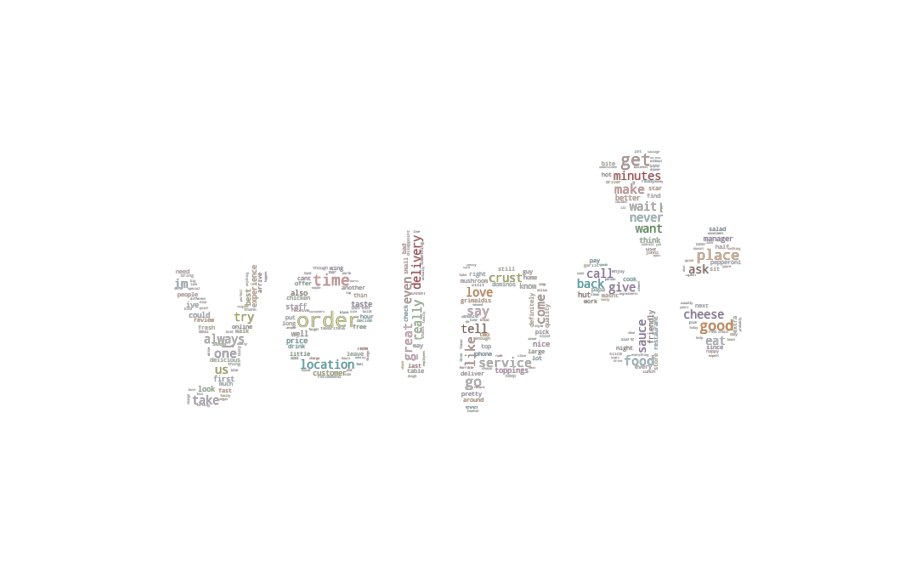

In [95]:
makeImage(vocab_tf,'Yelp.png','test2.png')

# play

In [96]:
nameset=set(df['name'])
[x for x in nameset if re.search(r'(?i)papa',x)]

["Papa Murphy's", "Papa John's Pizza"]